# Introduction

### In this learning episode, I will explore the following concepts:<br>
<br>
-Different Normalization Methods<br>
<br>
-Plotting an entire df<br>
<br>
-Sampling an imbalanced dataset<br>
<br>
<br>
-StratifiedKFold()<br>
<br>
-Binary Classification<br>
<br>
-Multiple Linear Regression<br>
<br>
-Kolmogorov-Smirnov (inference)<br>
<br>
<br>
-Curve Fitting<br>
<br>
-ROC Curve<br>

<br>


My intention is to learn as much as possible about these concepts in use. The items discussed are what I found online and decided to use them.


# Load

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn import metrics
import seaborn as sns
import pandas as pd
from scipy.stats import skew

from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from scipy.stats import ks_2samp
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from notebooks.utilities.utilities import *

import numpy as np

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')



data_path = '/Users/mimi/Desktop/PYTHON/TURING/HOME/DA/SPRINT_3/data/winequality-red.csv'
df = pd.read_csv(data_path)
print(df[df.duplicated()==True].shape[0])
df.drop_duplicates(inplace=True)
print(df.shape)
print(df.isna().any().sum())

small_constant = 1e-10
df_log = np.log1p(df.iloc[:, :-1] + small_constant)
df_log['quality'] = df['quality']

#plt.rcParams['axes.prop_cycle'] = cycler('color', [])

240
(1359, 12)
0


# EDA

In [6]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


In [7]:
df.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.00,8.31,1.74,4.60,7.10,7.90,9.20,15.90
volatile acidity,1359.00,0.53,0.18,0.12,0.39,0.52,0.64,1.58
citric acid,1359.00,0.27,0.20,0.00,0.09,0.26,0.43,1.00
residual sugar,1359.00,2.52,1.35,0.90,1.90,2.20,2.60,15.50
chlorides,1359.00,0.09,0.05,0.01,0.07,0.08,0.09,0.61
free sulfur dioxide,1359.00,15.89,10.45,1.00,7.00,14.00,21.00,72.00
total sulfur dioxide,1359.00,46.83,33.41,6.00,22.00,38.00,63.00,289.00
density,1359.00,1.00,0.00,0.99,1.00,1.00,1.00,1.00
pH,1359.00,3.31,0.16,2.74,3.21,3.31,3.40,4.01
sulphates,1359.00,0.66,0.17,0.33,0.55,0.62,0.73,2.00


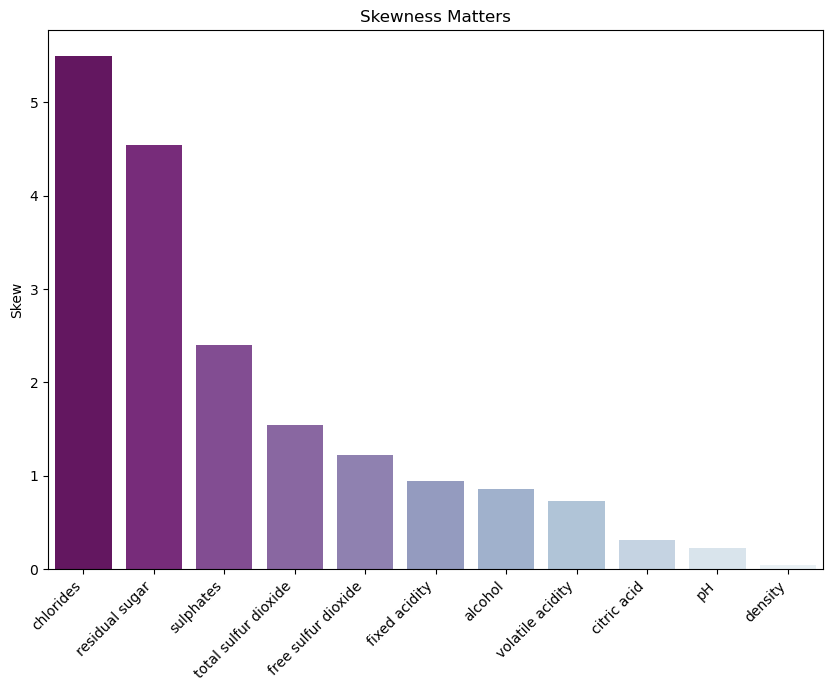

In [8]:
skewed_features = df.iloc[:, :-1].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skewed_features})   

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_title("Skewness Matters")

sns.barplot(x=skewness.index, y=skewness['Skew'], palette="BuPu_r")
plt.xticks(rotation=45, ha='right')  
plt.show()

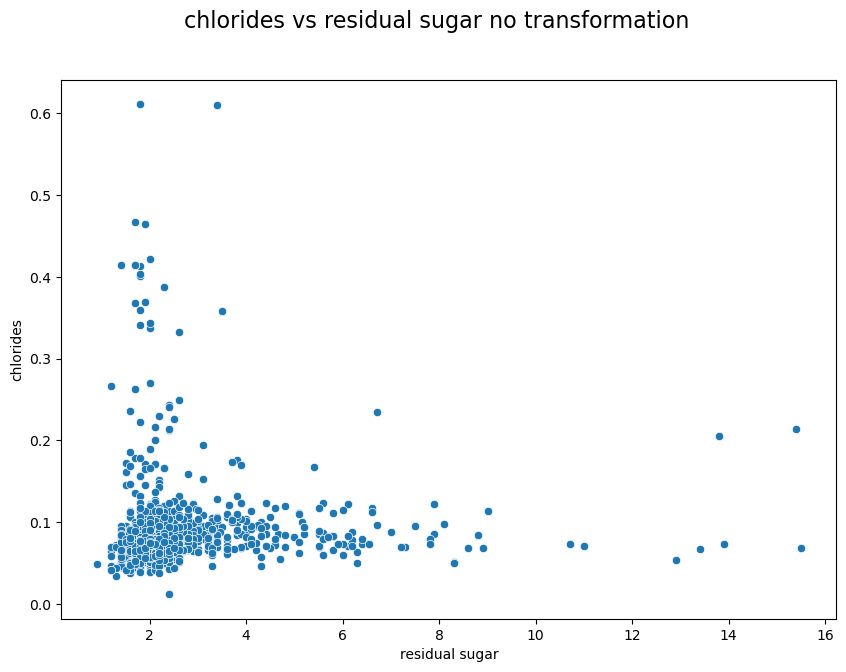

In [9]:
fig, ax = plt.subplots(figsize=(10, 7)) 
sns.scatterplot(y=df['chlorides'], x=df['residual sugar'], palette="BuPu_r") 

fig.suptitle("chlorides vs residual sugar no transformation", fontsize=16)
plt.show()

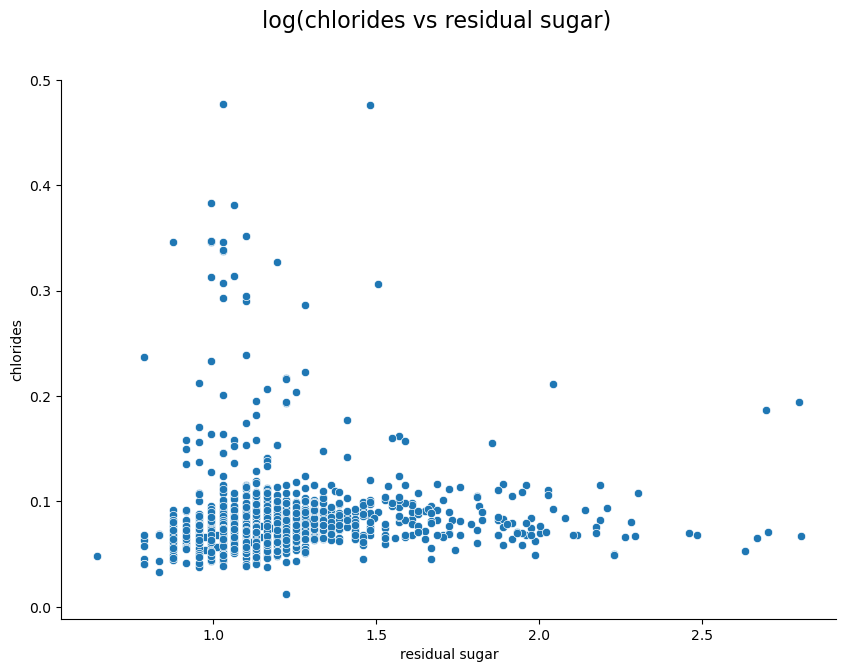

In [10]:
fig, ax = plt.subplots(figsize=(10, 7)) 
sns.scatterplot(y=df_log['chlorides'], x=df_log['residual sugar'], palette="BuPu_r") 

fig.suptitle("log(chlorides vs residual sugar)", fontsize=16)

sns.despine()
plt.show()

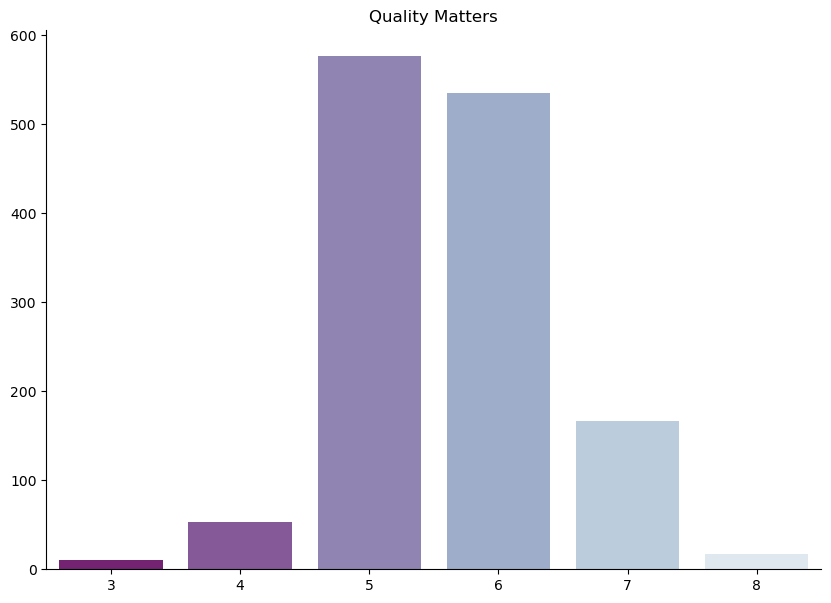

In [11]:
quality = df['quality'].value_counts().reset_index()
color = sns.color_palette("BuPu_r")

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_title("Quality Matters")

sns.barplot(x=quality['index'].values,
            y=quality['quality'].values, palette="BuPu_r" )
sns.despine()

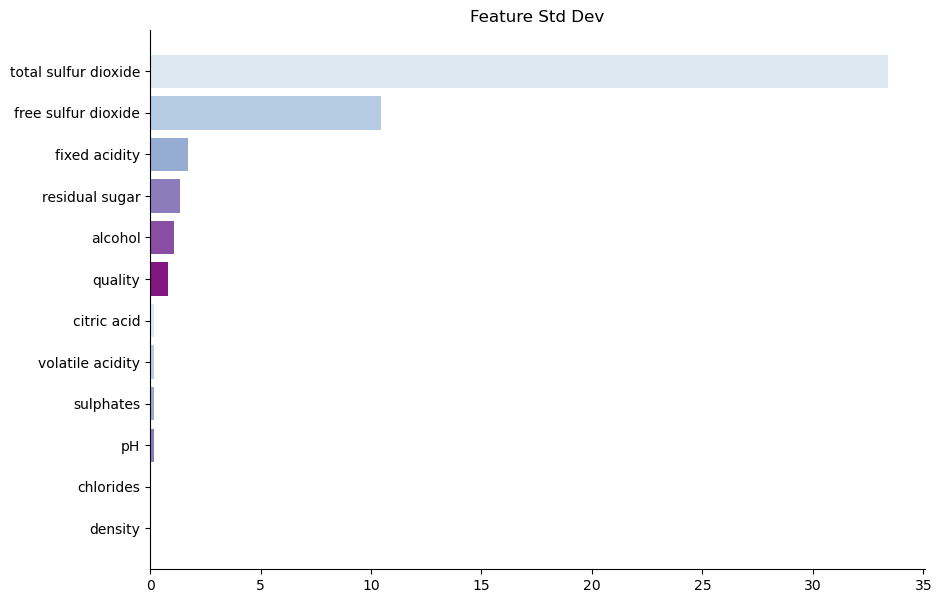

In [12]:
standard_dev = df.describe().loc['std'].sort_values()

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(standard_dev.index, standard_dev.values, color=sns.color_palette("BuPu_r"))
ax.set_title('Feature Std Dev')
sns.despine()

plt.show()

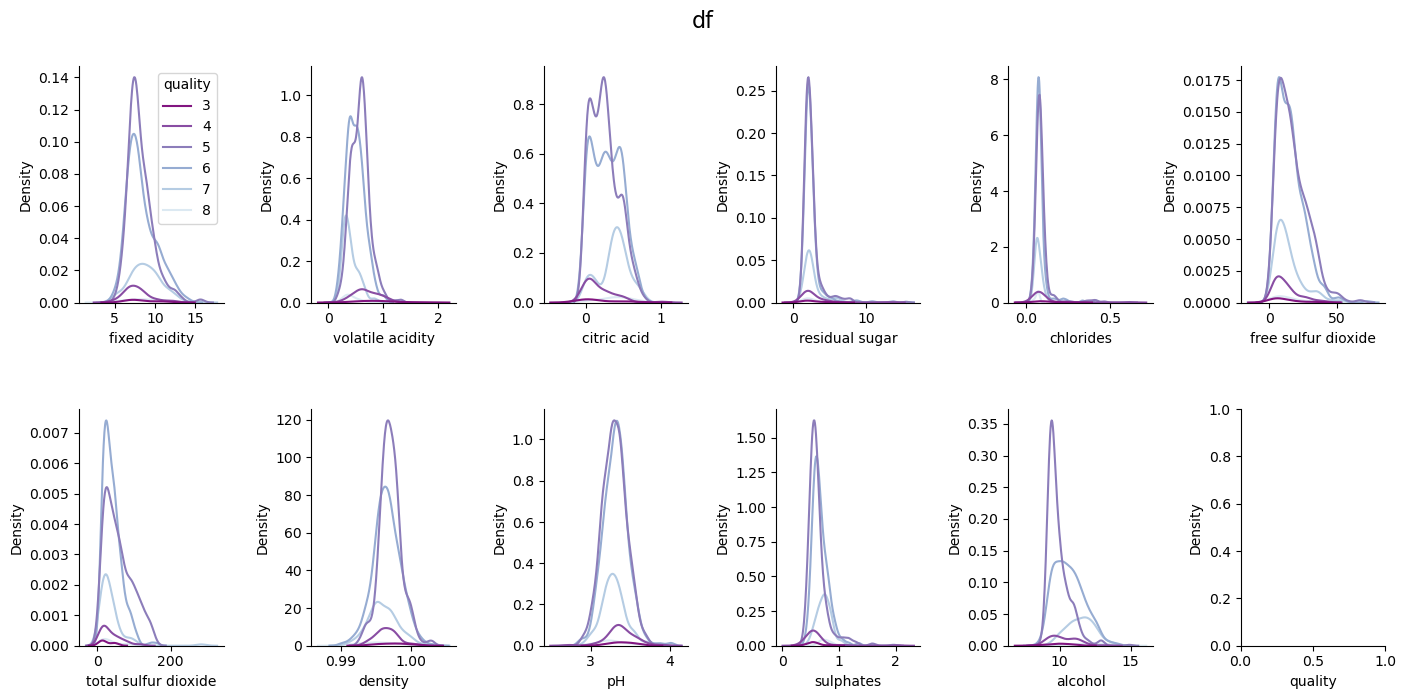

In [13]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14, 7))
index = 0
ax = ax.flatten()

for col, value in df.items():
    legend = index == 0
    sns.kdeplot(x=col, data=df, ax=ax[index], hue=df['quality'].astype('category'), palette="BuPu_r", legend=legend, warn_singular=False)
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
sns.despine()
fig.suptitle("df", fontsize=16)
plt.show()

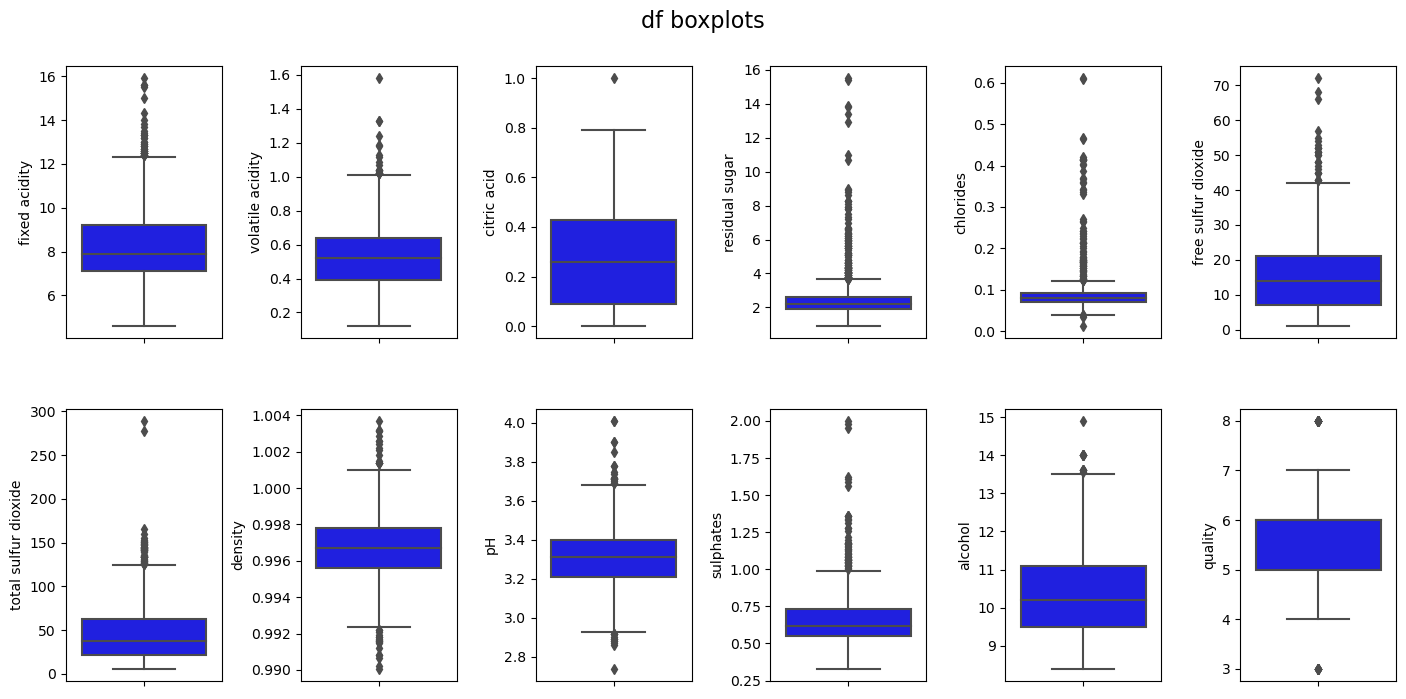

In [14]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14, 7))
index = 0
ax = ax.flatten()

for col, value in df.items():
    sns.boxplot(y=col, data=df, color='b', ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
fig.suptitle("df boxplots", fontsize=16)
plt.show()

# Sampled EDA

In [15]:
sampled_df = df[df['quality'] == 5].sample(10)
for val in df['quality'].value_counts().index[1:]:
    sampled_df = sampled_df.append(df[df['quality'] == val].sample(10))

In [16]:
from sklearn.preprocessing import MinMaxScaler



MinMaxScaler = MinMaxScaler()
scaled_values = MinMaxScaler.fit_transform(df.iloc[:, :-1]) 
df_scaled_MM = pd.DataFrame(scaled_values, columns=df.iloc[:, :-1].columns)
df_scaled_MM['quality'] = df['quality'].to_numpy()
df_scaled_MM.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.00,0.33,0.15,0.00,0.22,0.29,0.41,1.00
volatile acidity,1359.00,0.28,0.13,0.00,0.18,0.27,0.36,1.00
citric acid,1359.00,0.27,0.20,0.00,0.09,0.26,0.43,1.00
residual sugar,1359.00,0.11,0.09,0.00,0.07,0.09,0.12,1.00
chlorides,1359.00,0.13,0.08,0.00,0.10,0.11,0.13,1.00
free sulfur dioxide,1359.00,0.21,0.15,0.00,0.08,0.18,0.28,1.00
total sulfur dioxide,1359.00,0.14,0.12,0.00,0.06,0.11,0.20,1.00
density,1359.00,0.49,0.14,0.00,0.41,0.49,0.57,1.00
pH,1359.00,0.45,0.12,0.00,0.37,0.45,0.52,1.00
sulphates,1359.00,0.20,0.10,0.00,0.13,0.17,0.24,1.00


In [17]:
'''

PowerTransformer applies a power transformation to each feature to make the data more Gaussian-like in order to stabilize variance and minimize skewness. 
Currently the Yeo-Johnson and Box-Cox transforms are supported and the optimal scaling factor is determined via maximum likelihood estimation in both methods. 
By default, PowerTransformer applies zero-mean, unit variance normalization. Note that Box-Cox can only be applied to strictly positive data. 
Income and average house occupancy happen to be strictly positive, but if negative values are present the Yeo-Johnson transformed is preferred.
'''
from sklearn.preprocessing import PowerTransformer
power_transform = PowerTransformer()
power_values = power_transform.fit_transform(df.iloc[:, :-1]) 
df_power = pd.DataFrame(power_values, columns=df.iloc[:, :-1].columns)
df_power['quality'] = df['quality'].to_numpy()
df_power.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.00,-0.00,1.00,-3.34,-0.66,-0.10,0.66,2.83
volatile acidity,1359.00,0.00,1.00,-3.01,-0.74,0.06,0.70,3.63
citric acid,1359.00,-0.00,1.00,-1.53,-0.93,0.04,0.85,2.86
residual sugar,1359.00,0.00,1.00,-5.06,-0.60,-0.01,0.56,2.57
chlorides,1359.00,-0.00,1.00,-6.66,-0.50,-0.01,0.52,2.81
free sulfur dioxide,1359.00,-0.00,1.00,-2.95,-0.91,0.09,0.71,2.78
total sulfur dioxide,1359.00,0.00,1.00,-2.42,-0.73,0.03,0.75,3.02
density,1359.00,-0.00,1.00,-3.62,-0.59,0.00,0.60,3.67
pH,1359.00,0.00,1.00,-4.10,-0.63,0.03,0.60,4.04
sulphates,1359.00,-0.00,1.00,-4.08,-0.68,-0.04,0.71,2.87


In [18]:



MinMaxScaler = MinMaxScaler()
scaled_values = MinMaxScaler.fit_transform(df.iloc[:, :-1]) 
df_scaled_MM = pd.DataFrame(scaled_values, columns=df.iloc[:, :-1].columns)
df_scaled_MM['quality'] = df['quality'].to_numpy()
df_scaled_MM.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.00,0.33,0.15,0.00,0.22,0.29,0.41,1.00
volatile acidity,1359.00,0.28,0.13,0.00,0.18,0.27,0.36,1.00
citric acid,1359.00,0.27,0.20,0.00,0.09,0.26,0.43,1.00
residual sugar,1359.00,0.11,0.09,0.00,0.07,0.09,0.12,1.00
chlorides,1359.00,0.13,0.08,0.00,0.10,0.11,0.13,1.00
free sulfur dioxide,1359.00,0.21,0.15,0.00,0.08,0.18,0.28,1.00
total sulfur dioxide,1359.00,0.14,0.12,0.00,0.06,0.11,0.20,1.00
density,1359.00,0.49,0.14,0.00,0.41,0.49,0.57,1.00
pH,1359.00,0.45,0.12,0.00,0.37,0.45,0.52,1.00
sulphates,1359.00,0.20,0.10,0.00,0.13,0.17,0.24,1.00


In [19]:
from sklearn.preprocessing import StandardScaler


    
#StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.


standard_scaler = StandardScaler()
scaled_values = standard_scaler.fit_transform(df.iloc[:, :-1]) 
df_scaled_S = pd.DataFrame(scaled_values, columns=df.iloc[:, :-1].columns)
df_scaled_S['quality'] = df['quality'].to_numpy()
df_scaled_S.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.00,-0.00,1.00,-2.14,-0.70,-0.24,0.51,4.37
volatile acidity,1359.00,0.00,1.00,-2.24,-0.76,-0.05,0.60,5.74
citric acid,1359.00,0.00,1.00,-1.39,-0.93,-0.06,0.81,3.72
residual sugar,1359.00,-0.00,1.00,-1.20,-0.46,-0.24,0.06,9.60
chlorides,1359.00,0.00,1.00,-1.54,-0.37,-0.18,0.06,10.59
free sulfur dioxide,1359.00,-0.00,1.00,-1.43,-0.85,-0.18,0.49,5.37
total sulfur dioxide,1359.00,0.00,1.00,-1.22,-0.74,-0.26,0.48,7.25
density,1359.00,0.00,1.00,-3.55,-0.59,-0.00,0.59,3.74
pH,1359.00,-0.00,1.00,-3.68,-0.64,0.00,0.58,4.52
sulphates,1359.00,-0.00,1.00,-1.93,-0.64,-0.23,0.42,7.86


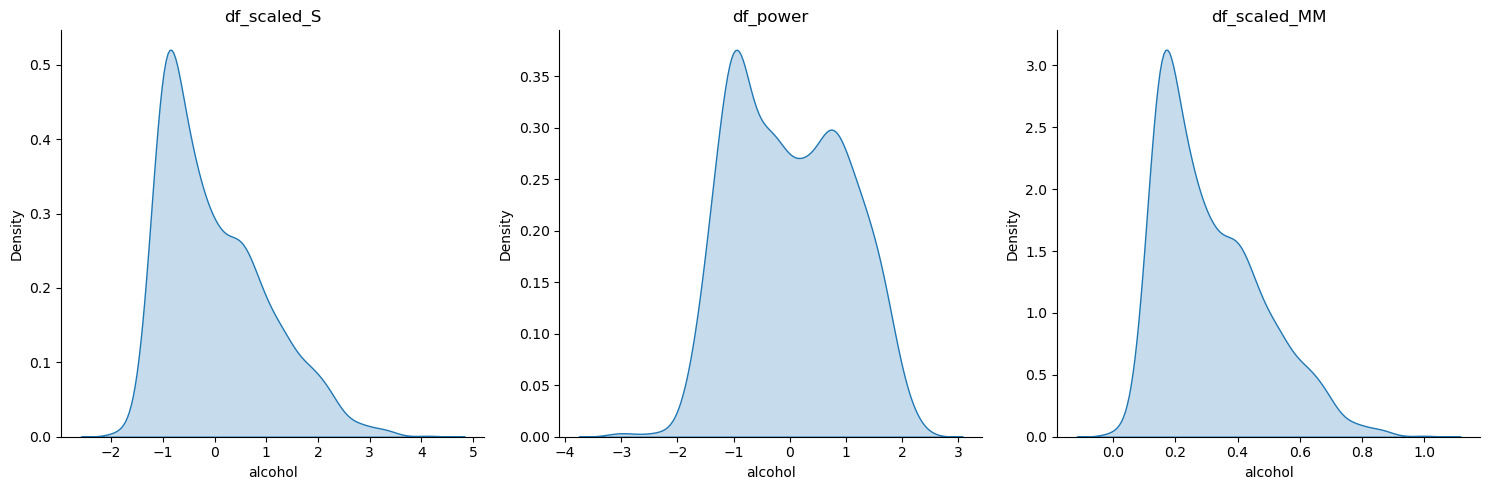

In [20]:
ig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.kdeplot(x='alcohol', data=df_scaled_S, ax=ax[0], warn_singular=False, fill=True)
ax[0].set_title('df_scaled_S')

sns.kdeplot(x='alcohol', data=df_power, ax=ax[1], warn_singular=False,fill=True)
ax[1].set_title('df_power')

sns.kdeplot(x='alcohol', data=df_scaled_MM, warn_singular=False, ax=ax[2],fill=True)
ax[2].set_title('df_scaled_MM')
sns.despine()
plt.tight_layout()
plt.show()

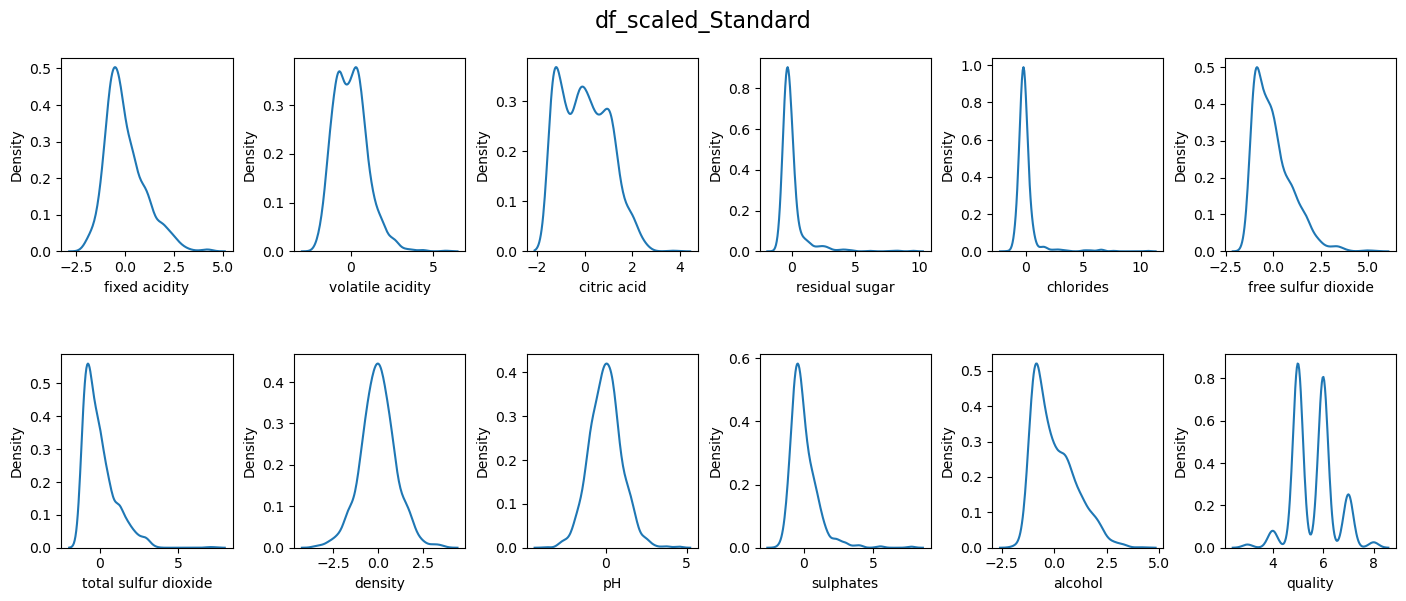

In [21]:
#hue=df_scaled['quality'].astype('category'),palette="BuPu_r",
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14,6))
index = 0
ax = ax.flatten()

for col, value in df_scaled_S.items():
    legend = index == 0
    sns.kdeplot(x=col, data=df_scaled_S, ax=ax[index], legend=legend, warn_singular=False)
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
fig.suptitle("df_scaled_Standard", fontsize=16)
plt.show()


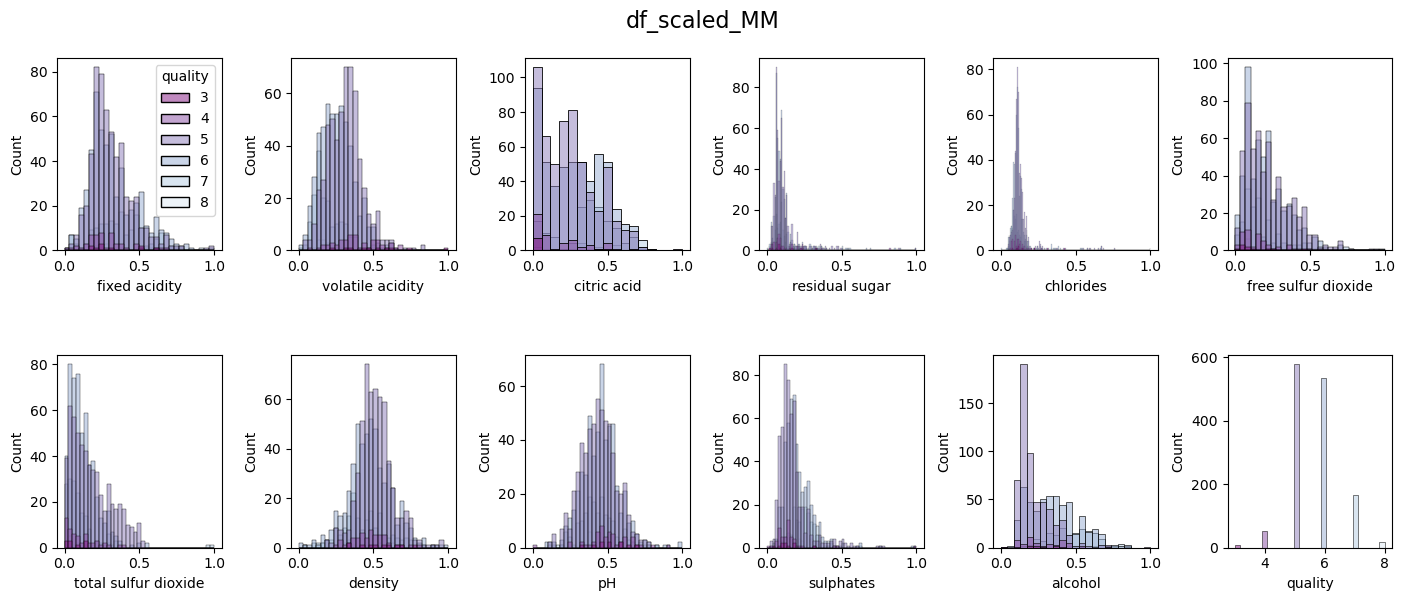

In [22]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14,6))
index = 0
ax = ax.flatten()

for col, value in df_scaled_MM.items():
    legend = index == 0
    sns.histplot(x=col, data=df_scaled_MM, ax=ax[index], hue=df_scaled_MM['quality'].astype('category'),palette="BuPu_r", legend=legend)
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
fig.suptitle("df_scaled_MM", fontsize=16)
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

scaled_values_ = standard_scaler.fit_transform(sampled_df.iloc[:, :-1]) 
df_scaled_sampled = pd.DataFrame(scaled_values_, columns=df.iloc[:, :-1].columns)
df_scaled_sampled['quality'] = sampled_df['quality'].to_numpy()
df_scaled_sampled.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
fixed acidity,60.00,-0.00,1.01,-1.92,-0.65,-0.25,0.63,2.72
volatile acidity,60.00,-0.00,1.01,-1.36,-0.88,-0.09,0.38,4.06
citric acid,60.00,-0.00,1.01,-1.33,-1.01,-0.11,0.85,2.05
residual sugar,60.00,0.00,1.01,-1.02,-0.54,-0.31,0.03,4.59
chlorides,60.00,0.00,1.01,-1.18,-0.41,-0.21,-0.04,5.19
free sulfur dioxide,60.00,0.00,1.01,-1.15,-0.81,-0.46,0.70,2.78
total sulfur dioxide,60.00,0.00,1.01,-0.79,-0.65,-0.30,0.44,5.79
density,60.00,-0.00,1.01,-2.73,-0.50,-0.02,0.71,2.14
pH,60.00,-0.00,1.01,-2.19,-0.59,0.02,0.59,2.80
sulphates,60.00,0.00,1.01,-1.49,-0.67,-0.21,0.32,3.84


Text(0.5, 0.98, 'sampled_df')

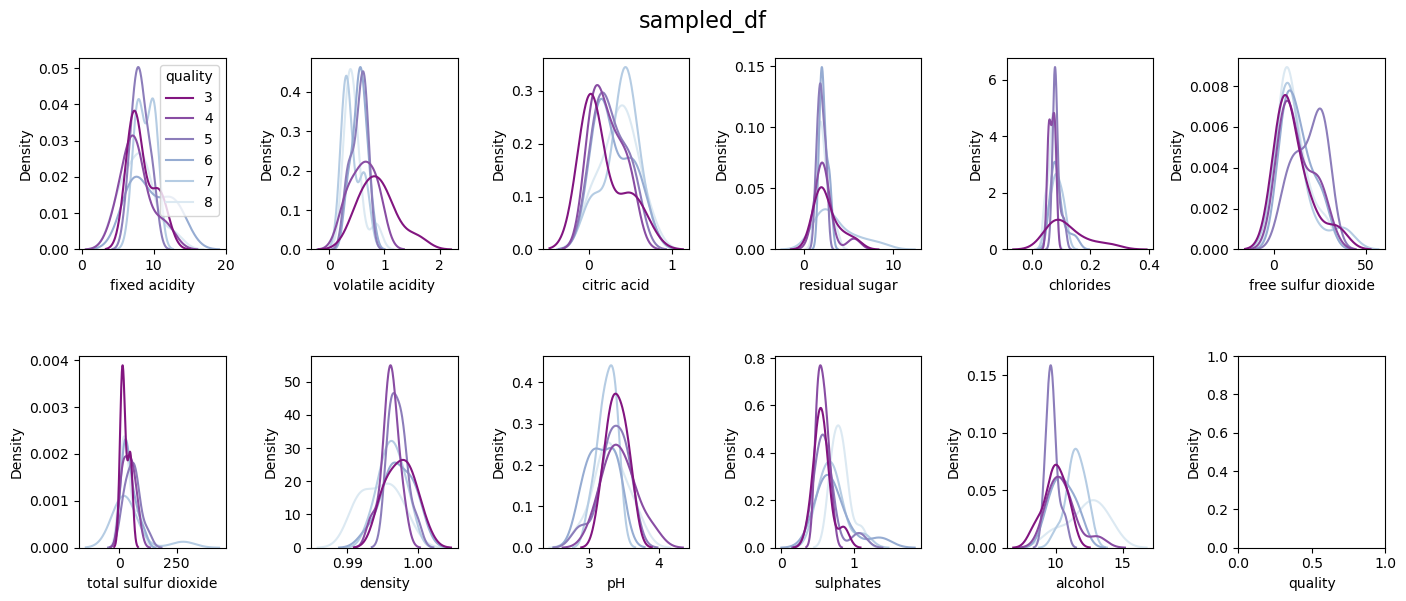

In [24]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14,6))
index = 0
ax = ax.flatten()

for col, value in sampled_df.items():
    legend = index == 0
    sns.kdeplot(x=col, data=sampled_df, palette="BuPu_r", hue=sampled_df['quality'].astype('category'), ax=ax[index], fill=False, legend=legend)
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
fig.suptitle("sampled_df", fontsize=16)

Text(0.5, 1.0, 'Sampled and Scaled')

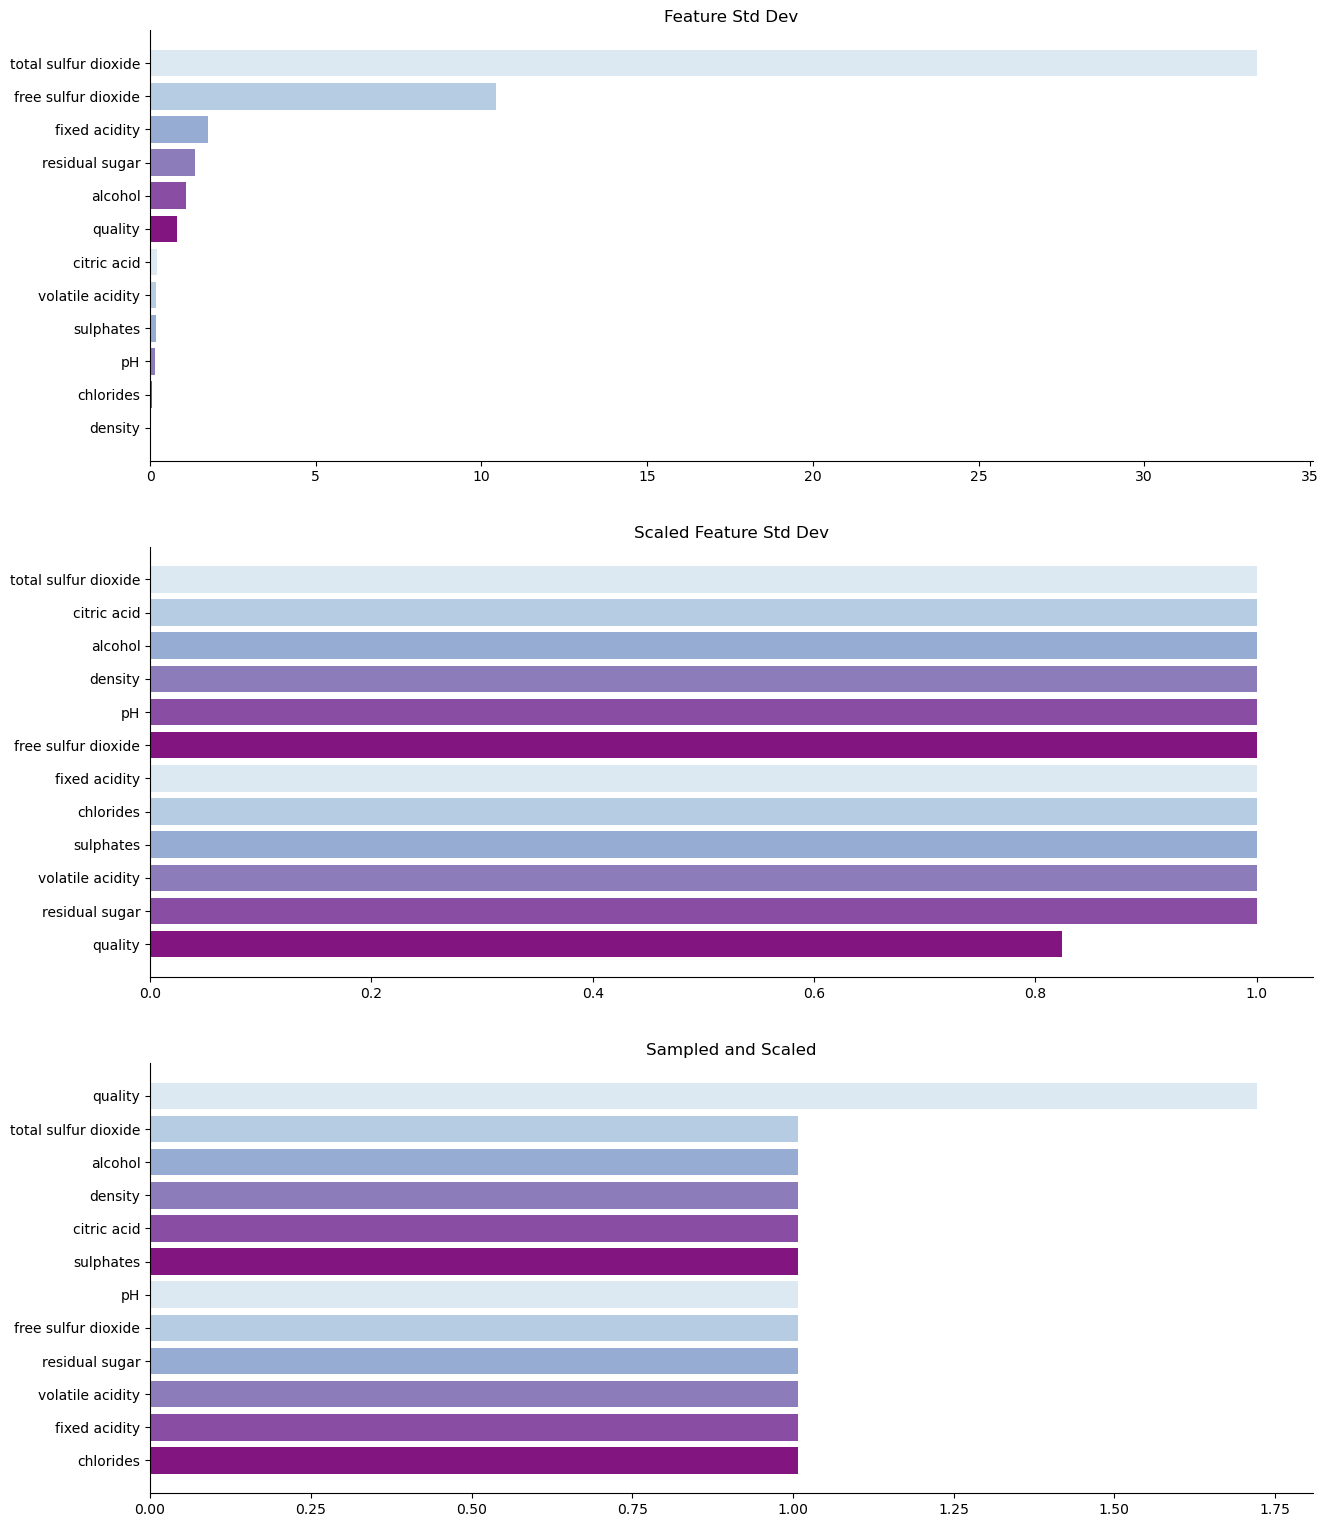

In [25]:
standard_dev = df.describe().loc['std'].sort_values()
scaled_std_dev = df_scaled_S.describe().loc['std'].sort_values()
sam_scaled_dev = df_scaled_sampled.describe().loc['std'].sort_values()


fig, ax = plt.subplots(3,1, figsize=(15,19))

ax[0].barh(standard_dev.index, standard_dev.values, color=sns.color_palette("BuPu_r"))
ax[0].set_title('Feature Std Dev')
sns.despine()
ax[1].barh(scaled_std_dev.index, scaled_std_dev.values, color=sns.color_palette("BuPu_r"))
ax[1].set_title('Scaled Feature Std Dev') 

ax[2].barh(sam_scaled_dev.index, sam_scaled_dev.values, color=sns.color_palette("BuPu_r"))
ax[2].set_title('Sampled and Scaled') 

Text(0.5, 0.98, 'df_scaled_Standard')

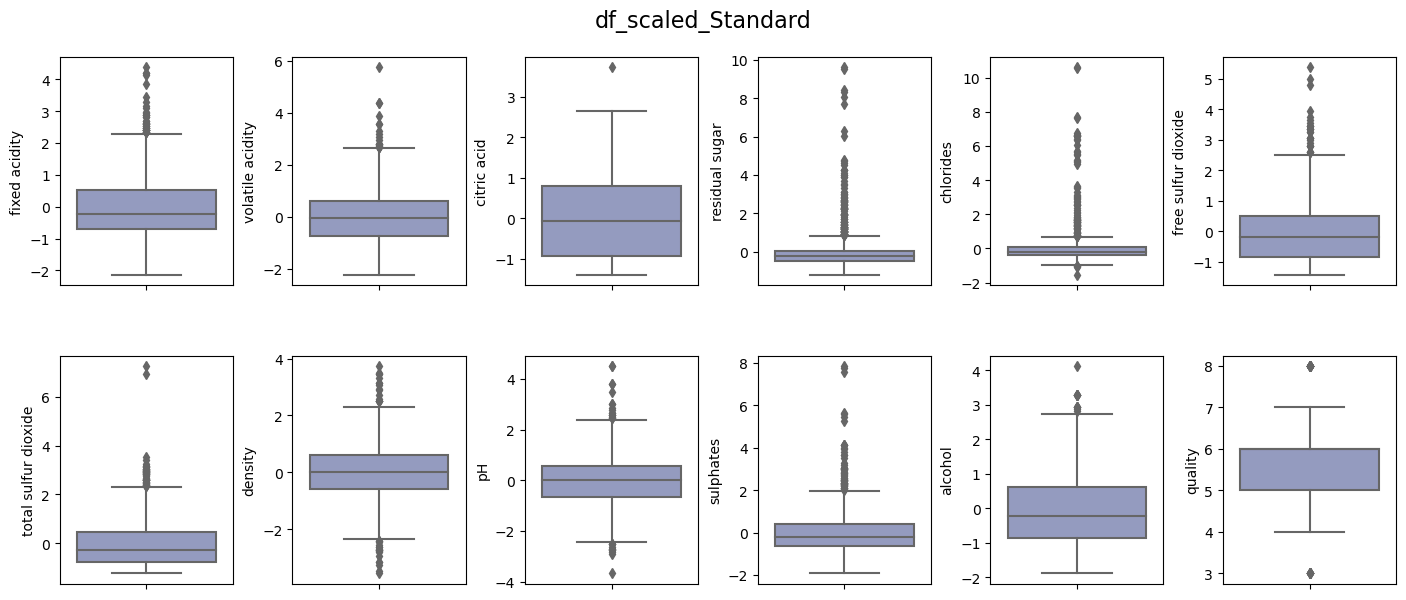

In [26]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14,6))
index = 0
ax = ax.flatten()

for col, value in df_scaled_S.items():
    sns.boxplot(y=col, data=df_scaled_S, palette="BuPu_r", ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
fig.suptitle("df_scaled_Standard", fontsize=16)


Text(0.5, 0.98, 'df_scaled_MM')

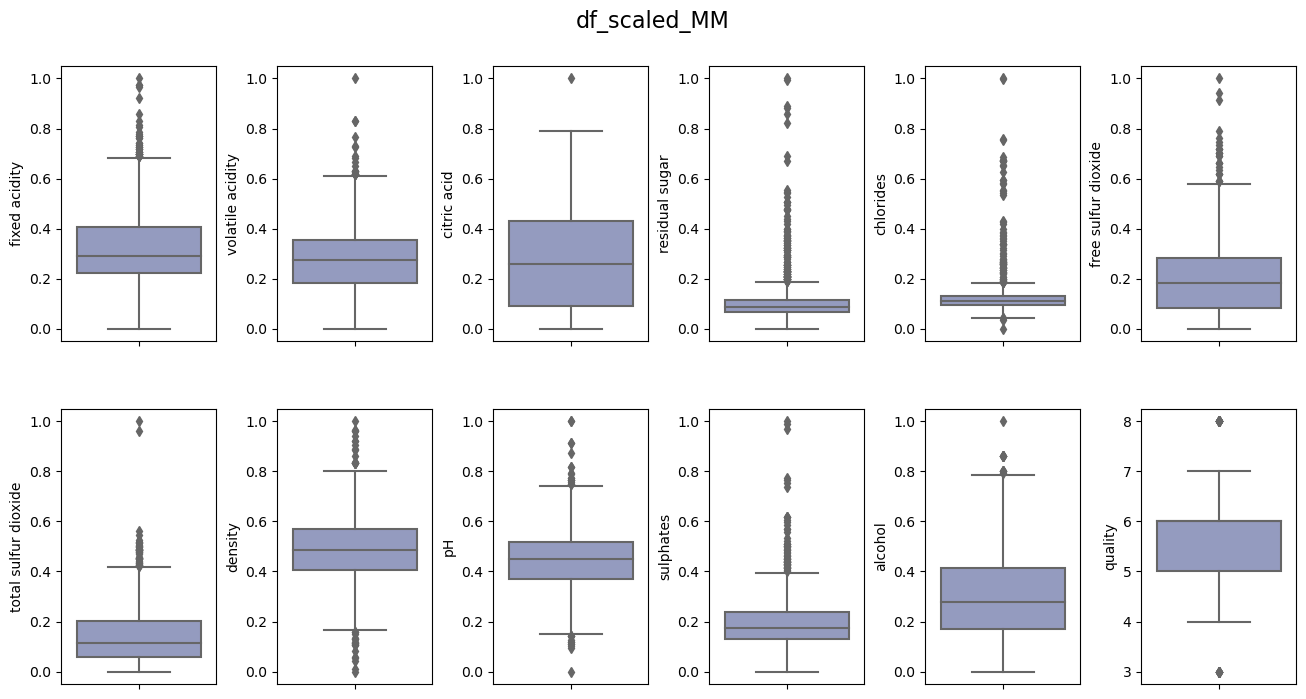

In [27]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(13,7))
index = 0
ax = ax.flatten()

for col, value in df_scaled_MM.items():
    sns.boxplot(y=col, data=df_scaled_MM, palette="BuPu_r", ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
fig.suptitle("df_scaled_MM", fontsize=16)


Text(0.5, 0.98, 'df_scaled_sampled')

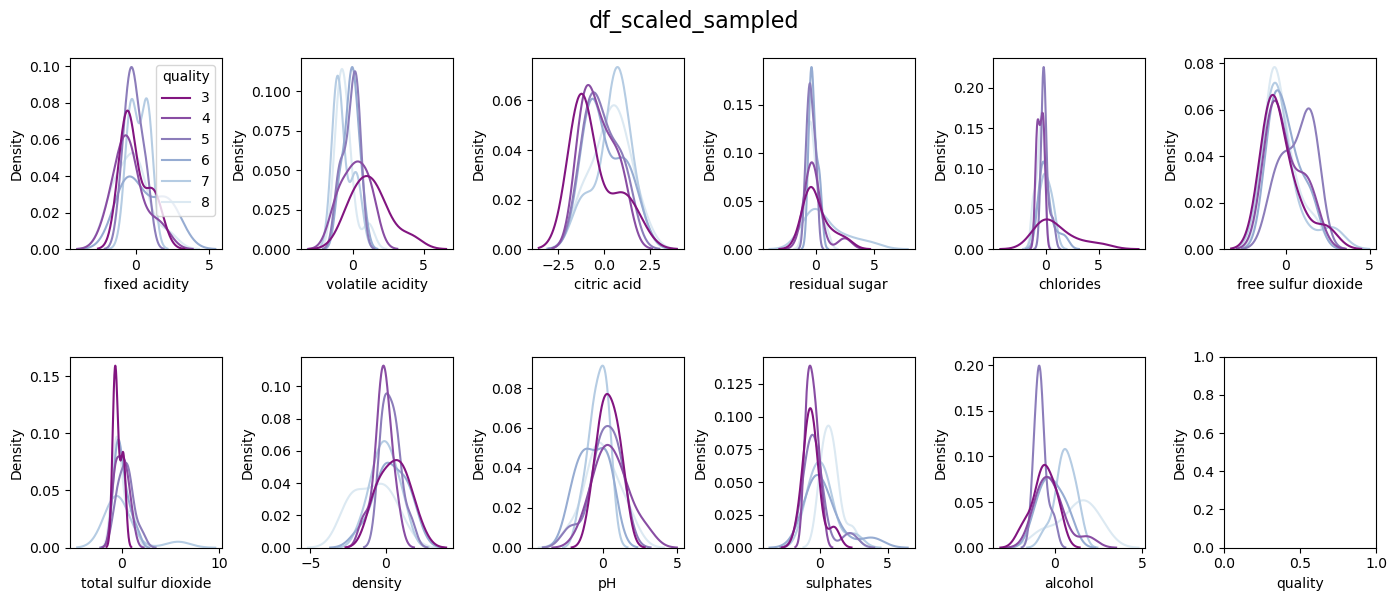

In [28]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14,6))
index = 0

ax = ax.flatten()

for col, value in df_scaled_sampled.items():
    legend = index == 0
    sns.kdeplot(x=col, data=df_scaled_sampled, color='b', ax=ax[index], palette="BuPu_r", hue=df_scaled_sampled['quality'].astype('category'), legend=legend, warn_singular=False)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)

fig.suptitle("df_scaled_sampled", fontsize=16)


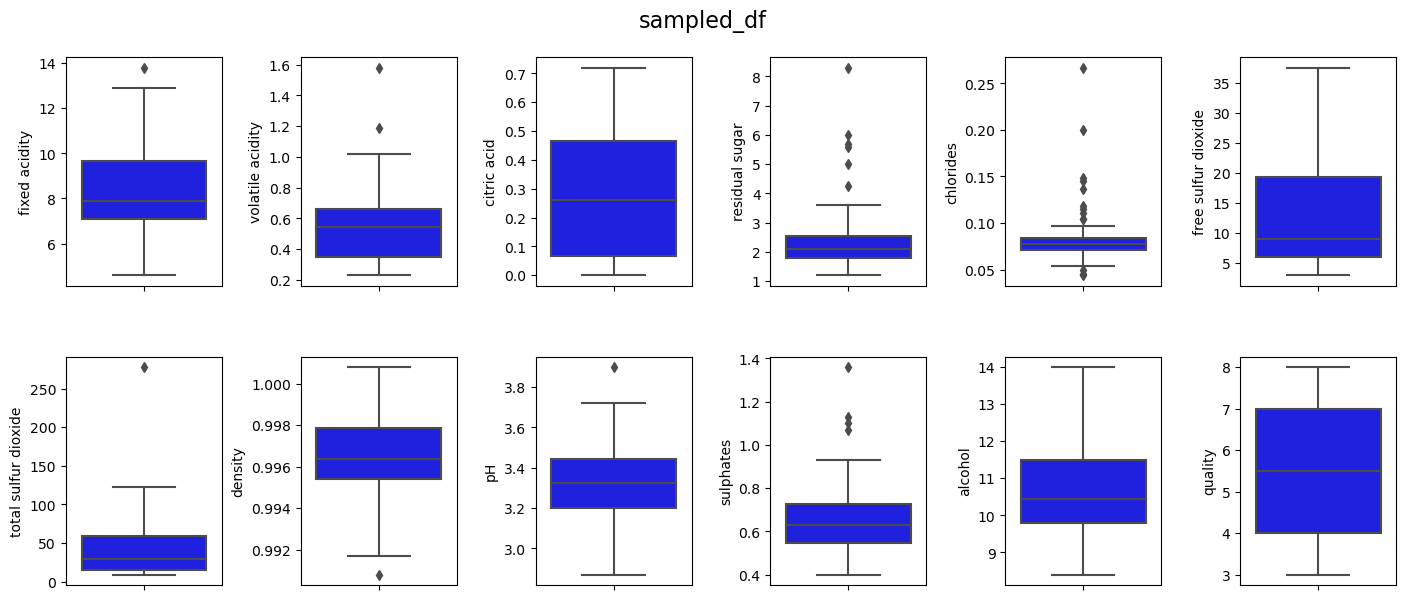

In [29]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14,6))
index = 0
ax = ax.flatten()

for col, value in sampled_df.items():
    sns.boxplot(y=col, data=sampled_df, color='b', ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
fig.suptitle("sampled_df", fontsize=16)
plt.show()


# Statistical Inference

On this episode, we will test whethere alcohol means of wine quality==5 is greater than the population (wine_df)!! <br>
<br>
Null Hypothesis - theres no difference between alcohol.mean() levels of wine['quality]==5 and the population['alcohol'].mean()<br>
<br>
Alternative Hypothesis theres a difference between alcohol.mean() levels of wine['quality]==5 and the population['alcohol'].mean()<br>
<br>
Test= One-Sample-Z-Test<br>
<br>
Alpha= 0.01<br>
<br>

In [30]:


sample_mean = df[df['quality'] == 5]['alcohol'].mean()
population_mean = df['alcohol'].mean()
population_std = df['alcohol'].std()
sample_size = len(df[df['quality'] == 5]['alcohol'])
alpha = 0.01
 
# compute the z-score
z_score = (sample_mean-population_mean)/(population_std/np.sqrt(50))
print('Z-Score :',z_score)
 
# Approach 1: Using Critical Z-Score
 
# Critical Z-Score
z_critical = stats.norm.ppf(1-alpha)
print('Critical Z-Score :',z_critical)
 
# Hypothesis
if z_score >  z_critical:
    print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")
 
# Approach 2: Using P-value
     
# P-Value : Probability of getting less than a Z-score
p_value = 1-stats.norm.cdf(z_score)
 
print('p-value :',p_value)
 
# Hypothesis
if p_value <  alpha:
    print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

Z-Score : -3.5533162254177895
Critical Z-Score : 2.3263478740408408
Fail to Reject Null Hypothesis
p-value : 0.9998097965578188
Fail to Reject Null Hypothesis


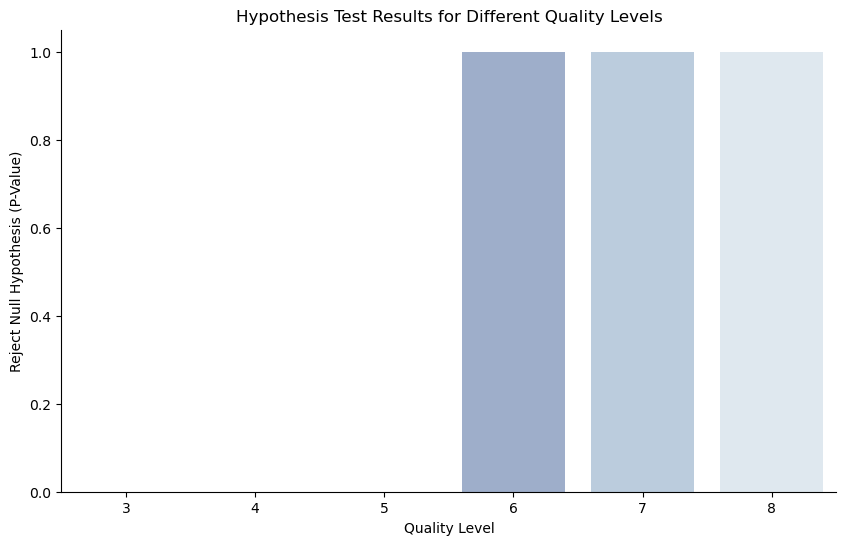

,Quality,Z-Score,Critical Z-Score,Reject Null (Critical Z-Score),P-Value,Reject Null (P-Value)
0,5,-12.216545,2.326348,False,1.0000,False
1,6,5.022842,2.326348,True,0.0000,True
2,7,12.659392,2.326348,True,0.0000,True
3,4,-1.090428,2.326348,False,0.8622,False
4,8,6.325328,2.326348,True,0.0000,True
5,3,-1.411687,2.326348,False,0.9210,False


In [61]:
def hypothesis_test_all_qualities(df, alpha=0.01):
    quality_values = df['quality'].unique()
    
    results = []

    for quality_value in quality_values:
        
        sample_mean = df[df['quality'] == quality_value]['alcohol'].mean()
        population_mean = df['alcohol'].mean()
        population_std = df['alcohol'].std()
        sample_size = len(df[df['quality'] == quality_value]['alcohol'])
        
        
        z_score = (sample_mean - population_mean) / (population_std / np.sqrt(sample_size))
        
        
        z_critical = stats.norm.ppf(1 - alpha)
        
        
        reject_null_critical = z_score > z_critical
        
        
        p_value = round(1 - stats.norm.cdf(z_score), 4)
        

        reject_null_p_value = p_value < alpha
        

        results.append({
            'Quality': quality_value,
            'Z-Score': z_score,
            'Critical Z-Score': z_critical,
            'Reject Null (Critical Z-Score)': reject_null_critical,
            'P-Value': p_value,
            'Reject Null (P-Value)': reject_null_p_value
        })

    results_df = pd.DataFrame(results)

    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Quality', y='Reject Null (P-Value)', data=results_df, palette='BuPu_r')
    plt.title('Hypothesis Test Results for Different Quality Levels')
    plt.xlabel('Quality Level')
    plt.ylabel('Reject Null Hypothesis (P-Value)')
    sns.despine()
    plt.show()
    

    return results_df


hypothesis_test_all_qualities(df_log)

# Logistic Regression

In [32]:
df['Y'] = [ 1 if x >= 7 else 0 for x in df['quality']]
X = df_log.drop(['quality'], axis=1)
Y = df['Y']

n_splits = 5  
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


for train_index, test_index in stratified_kfold.split(X, Y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = df["Y"].iloc[train_index], df["Y"].iloc[test_index]

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1088, 11) (1088,)
(271, 11) (271,)


In [33]:

logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(x_train, y_train)
y_pred = logisticRegr.predict(x_test)
y_train_pred = logisticRegr.predict(x_train)
y_test_pred = logisticRegr.predict(x_test)

print("Accuracy Score of Model on Training Data is =>",round(accuracy_score(y_train,y_train_pred)*100,2),"%")
print("Accuracy Score of Model on Testing Data  is =>",round(accuracy_score(y_test,y_test_pred)*100,2),"%")


Accuracy Score of Model on Training Data is => 87.22 %
Accuracy Score of Model on Testing Data  is => 87.08 %


Text(0.5, 427.9555555555555, 'Predicted label')

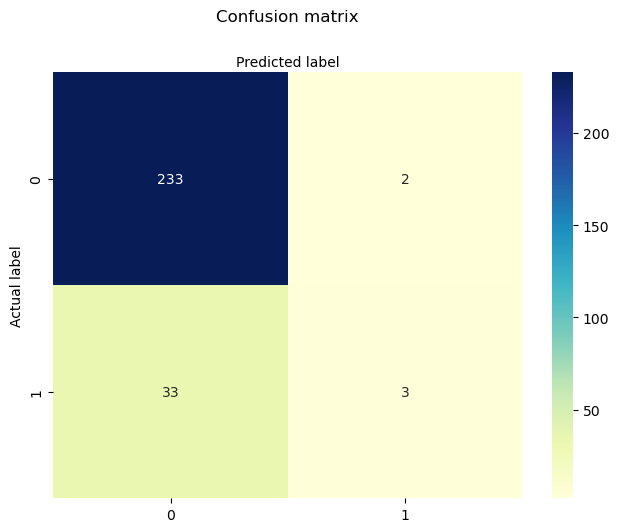

In [34]:

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



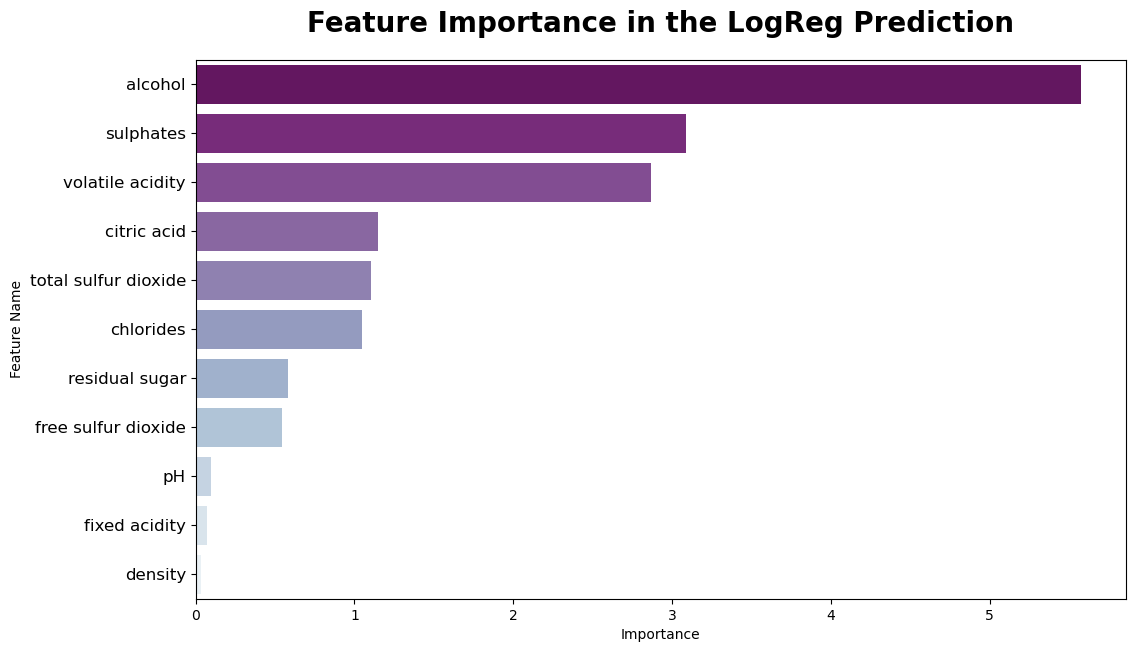

In [35]:
coefficients = logisticRegr.coef_[0]

imp_df = pd.DataFrame({"Feature Name":x_train.columns,
                       "Importance":np.abs(coefficients)})
features = imp_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importance", y="Feature Name", data=features, palette="BuPu_r")
plt.title("Feature Importance in the LogReg Prediction", fontweight="black", size=20, pad=20)
plt.yticks(size=12)
plt.show()

Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

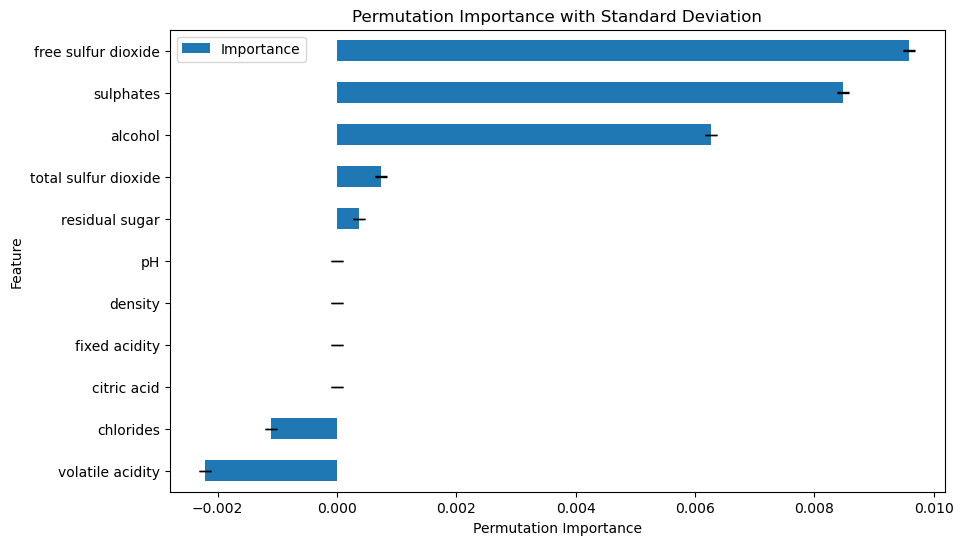

In [36]:
from sklearn.inspection import permutation_importance

result = permutation_importance(logisticRegr, x_test, y_test, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')

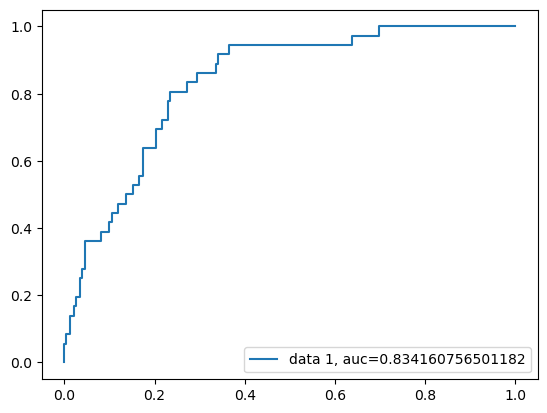

In [37]:
y_pred_proba = logisticRegr.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

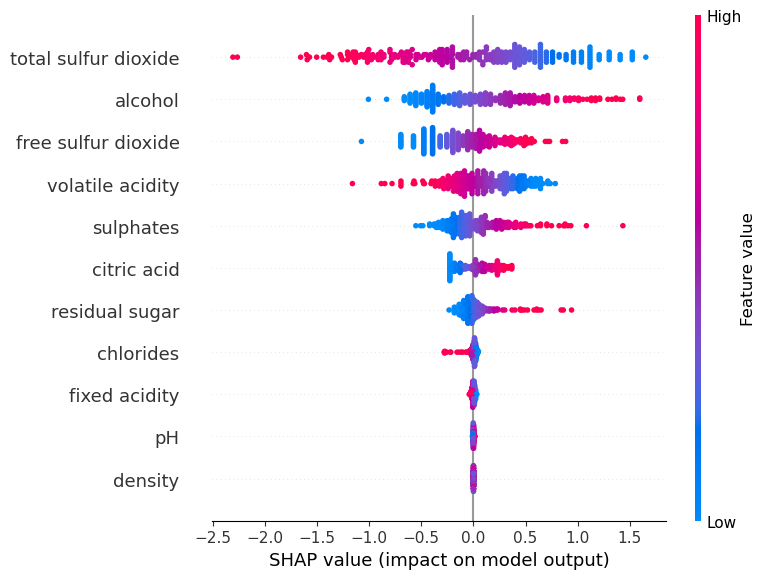

In [60]:

import shap

explainer = shap.Explainer(logisticRegr, x_train)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)



# Linear Regression

In [63]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [64]:
get_best_distribution(df['alcohol'])

p value for norm = 1.1138346021804662e-18
p value for exponweib = 2.77442174969624e-09
p value for weibull_max = 2.4204938386759435e-11
p value for weibull_min = 2.3322761697186964e-09
p value for pareto = 3.019894749296124e-101
p value for genextreme = 6.009197288400672e-10
Best fitting distribution: exponweib
Best p value: 2.77442174969624e-09
Parameters for the best fit: (12.191762479515347, 0.8178060726976826, 8.162041013827462, 0.5538332142576219)


('exponweib',
 2.77442174969624e-09,
 (12.191762479515347,
  0.8178060726976826,
  8.162041013827462,
  0.5538332142576219))

Meaning, the higher the p_score the closer the hypothesis is to reality.<br>
<br>
Weibull distribution uses<br>

In survival analysis<br>
<br>
In reliability engineering and failure analysis<br>
<br>
In electrical engineering to represent overvoltage occurring in an electrical system<br>
<br>
In industrial engineering to represent manufacturing and delivery times<br>

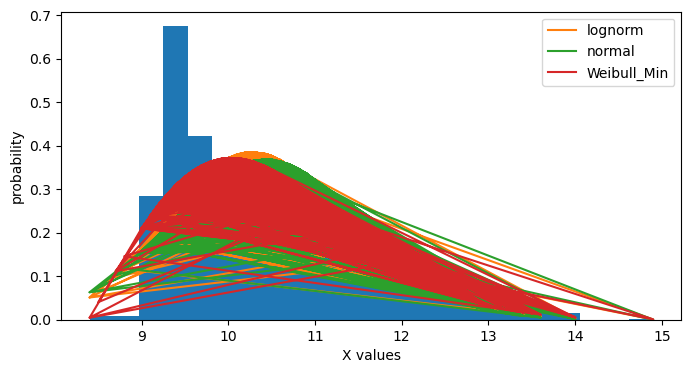

In [65]:
# fit lognormal distribution
shape, loc, scale = stats.lognorm.fit(df['alcohol'], loc=0)
pdf_lognorm = stats.lognorm.pdf(df['alcohol'], shape, loc, scale)

# fit normal distribution
mean, std = stats.norm.fit(df['alcohol'], loc=0)
pdf_norm = stats.norm.pdf(df['alcohol'], mean, std)

# fit weibull distribution
shape, loc, scale = stats.weibull_min.fit(df['alcohol'], loc=0)
pdf_weibull_min = stats.weibull_min.pdf(df['alcohol'], shape, loc, scale)


fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df['alcohol'], bins='auto', density=True)
ax.plot(df['alcohol'] , pdf_lognorm, label='lognorm')
ax.plot(df['alcohol'], pdf_norm, label='normal')
ax.plot(df['alcohol'], pdf_weibull_min, label='Weibull_Min')
ax.set_xlabel('X values')
ax.set_ylabel('probability')
ax.legend()

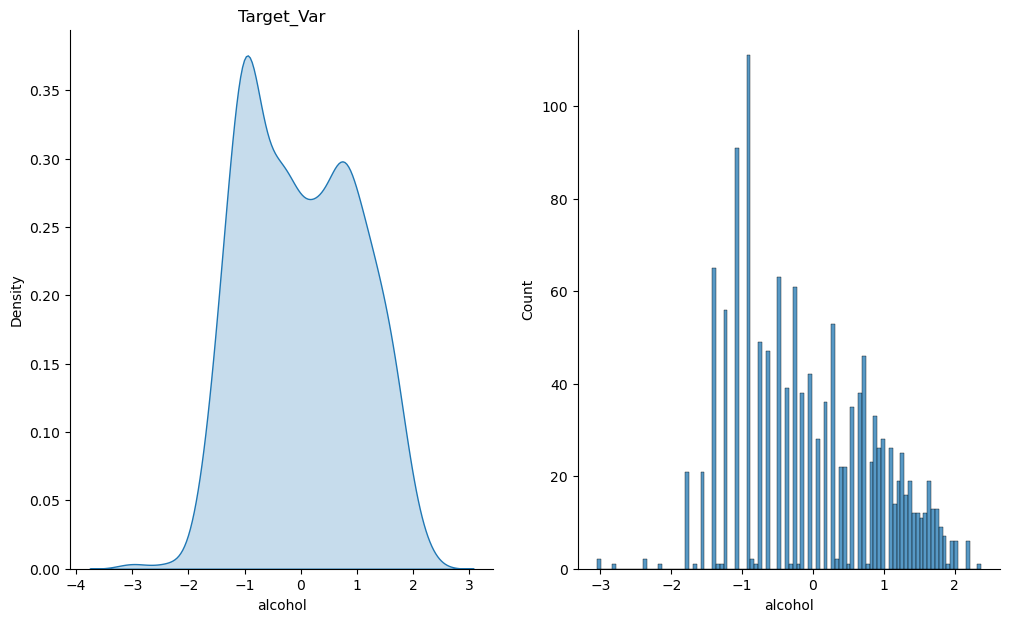

In [114]:
fig, ax = plt.subplots(1,2, figsize =(12, 7))

sns.kdeplot(x='alcohol', data=df_power, warn_singular=False, fill=True, ax=ax[0])
ax[0].set_title("Target_Var")


sns.histplot(df_power['alcohol'], bins=100, ax=ax[1])

sns.despine()
plt.show()

In [66]:
def create_folds(df, n_s=5, n_grp=None, task='classification'):
    df['Fold'] = -1
    
    if task == 'classification':
        if n_grp is None:
            kf = KFold(n_splits=n_s, shuffle=True, random_state=42)
            target = df.alcohol
        else:
            kf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=42)
            df['grp'] = pd.cut(df.alcohol, n_grp, labels=False)
            target = df.grp
    elif task == 'regression':
        kf = KFold(n_splits=n_s, shuffle=True, random_state=42)
        target = df.alcohol
    else:
        raise ValueError("Invalid task type. Use 'classification' or 'regression'")
    
    df.reset_index(drop=True, inplace=True)  
    
    if task == 'classification':
        for fold_no, (t, v) in enumerate(kf.split(target, target)):
            df.loc[v, 'Fold'] = fold_no
    elif task == 'regression':
        for fold_no, (t, v) in enumerate(kf.split(df)):
            df.loc[v, 'Fold'] = fold_no
            
    return df

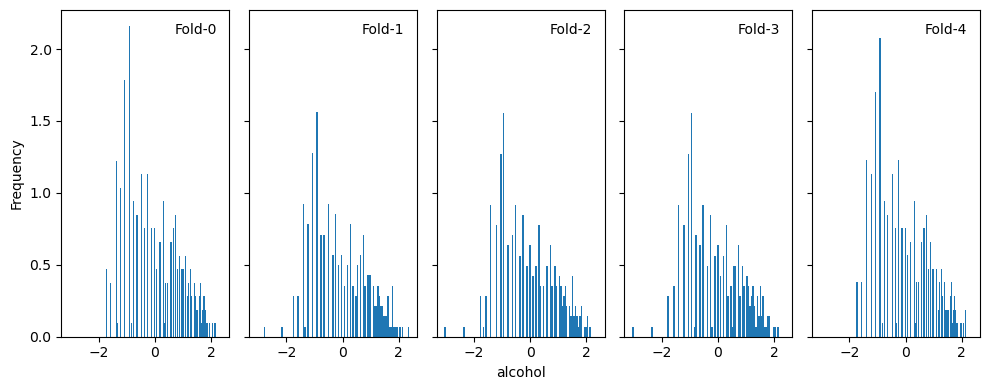

In [67]:
df__ = create_folds(df_power, n_s=5, n_grp=1000)

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,4))
for i, ax in enumerate(axs):
    ax.hist(df__[df__.Fold == i]['alcohol'], bins=100, density=True, label=f'Fold-{i}')
    if i == 0:
        ax.set_ylabel('Frequency')
    if i == 2:
        ax.set_xlabel("alcohol")
    ax.legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

In [68]:
for fold in np.sort(df__.Fold.unique()):
    if fold == 0:
        continue  # Skip the comparison with itself
    print(f'Fold 0 vs {fold}:', ks_2samp(df__.loc[df__.Fold==0, 'alcohol'], df__.loc[df__.Fold==fold, 'alcohol']))

Fold 0 vs 1: KstestResult(statistic=0.011029411764705883, pvalue=1.0, statistic_location=1.0159368212722568, statistic_sign=-1)
Fold 0 vs 2: KstestResult(statistic=0.011029411764705883, pvalue=1.0, statistic_location=-0.7710331652413263, statistic_sign=1)
Fold 0 vs 3: KstestResult(statistic=0.01838235294117647, pvalue=0.9999999999836938, statistic_location=0.5592170756280445, statistic_sign=-1)
Fold 0 vs 4: KstestResult(statistic=0.010039070978945084, pvalue=1.0, statistic_location=-0.9162482585448474, statistic_sign=1)


In [69]:
df_ = create_folds(df_power, n_s=5, n_grp=None)


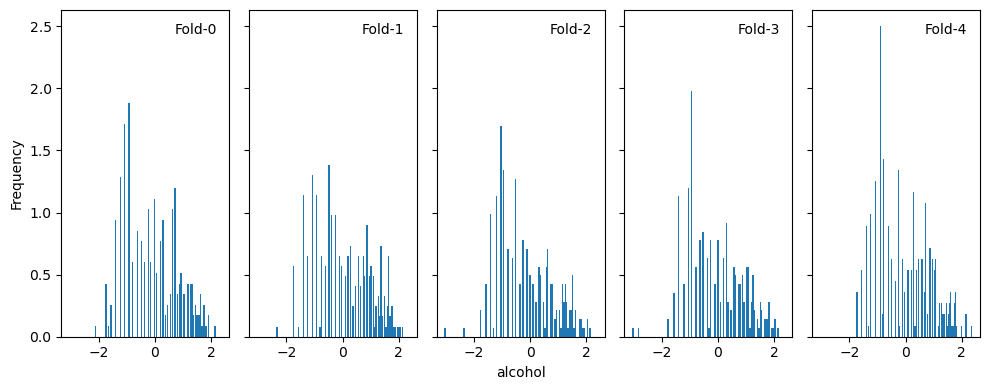

In [70]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,4))
for i, ax in enumerate(axs):
    ax.hist(df_[df_.Fold == i]['alcohol'], bins=100, density=True, label=f'Fold-{i}')
    if i == 0:
        ax.set_ylabel('Frequency')
    if i == 2:
        ax.set_xlabel("alcohol")
    ax.legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

In [71]:
for fold in np.sort(df_.Fold.unique())[1:]:
    print(f'Fold 0 vs {fold}:', ks_2samp(df_.loc[df_.Fold==0,'alcohol'], df_.loc[df_.Fold==fold,'alcohol']))

Fold 0 vs 1: KstestResult(statistic=0.06985294117647059, pvalue=0.5213483003638513, statistic_location=0.7235438562436123, statistic_sign=1)
Fold 0 vs 2: KstestResult(statistic=0.06985294117647059, pvalue=0.5213483003638513, statistic_location=-0.13370371679766457, statistic_sign=-1)
Fold 0 vs 3: KstestResult(statistic=0.029411764705882353, pvalue=0.9998093565080952, statistic_location=0.5592170756280445, statistic_sign=-1)
Fold 0 vs 4: KstestResult(statistic=0.0361406555242023, pvalue=0.9897259657878074, statistic_location=-1.0681569467644663, statistic_sign=1)


In [72]:
X = df__.drop(['alcohol','grp'], axis=1)
Y = df__['alcohol']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=X['Fold'])
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1019, 12)
(1019,)
(340, 12)
(340,)


In [73]:
from sklearn.metrics import mean_squared_error, r2_score
ols = linear_model.LinearRegression()
ols.fit(x_train, y_train)
y_train_pred = ols.predict(x_train)
y_test_pred = ols.predict(x_test)

# Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# R-squared
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Mean Squared Error on Training Data:", mse_train)
print("Mean Squared Error on Testing Data:", mse_test)
print("R-squared on Training Data:", r2_train)
print("R-squared on Testing Data:", r2_test)

Mean Squared Error on Training Data: 0.3159209296956374
Mean Squared Error on Testing Data: 0.40095922021140146
R-squared on Training Data: 0.6918138890407644
R-squared on Testing Data: 0.5664229819152117


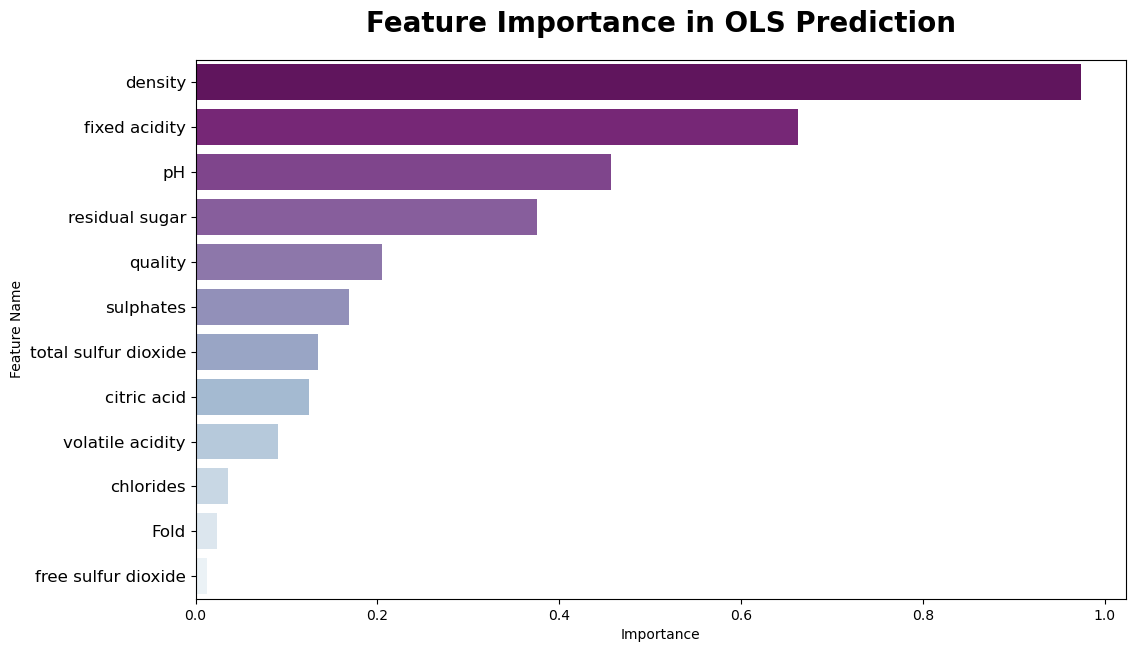

In [74]:
coefficients = ols.coef_

# Create a DataFrame to display feature names and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature Name': x_train.columns,  # Assuming x_train is your feature matrix
    'Importance': np.abs(coefficients)
})

# Sort the DataFrame by the absolute values of coefficients to highlight important features
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature Name', data=feature_importance, palette='BuPu_r')
plt.title('Feature Importance in OLS Prediction', fontweight='black', size=20, pad=20)
plt.yticks(size=12)
plt.show()


Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

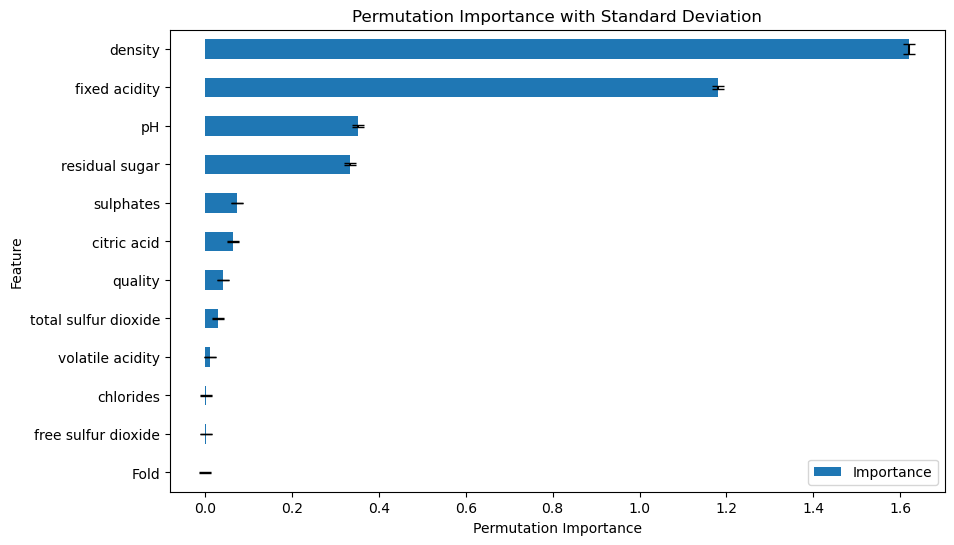

In [75]:
from sklearn.inspection import permutation_importance

result = permutation_importance(ols, x_test, y_test, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')

In [76]:
from statsmodels.stats.stattools import durbin_watson

residuals = y_train - ols.predict(x_train)
durbin_watson_statistic = durbin_watson(residuals)
print("Durbin-Watson Statistic:", durbin_watson_statistic)


Durbin-Watson Statistic: 1.9623249095202129


little evidence of autocorrelation in the residuals of your linear regression model. It indicates that the residuals are close to being independent.

In [77]:


name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
list(zip(name, test))

[('Jarque-Bera', 61.34445567125435),
 ('Chi^2 two-tail prob.', 4.777720100468278e-14),
 ('Skew', 0.2257560064433294),
 ('Kurtosis', 4.113980405984712)]

a high test statistic along with a low p-value suggests that there is evidence against the normality assumption for the residuals. This means that the distribution of residuals deviates significantly from a normal distribution. 

Text(0.5, 1.0, 'ols Residuals Q-Q Plot')

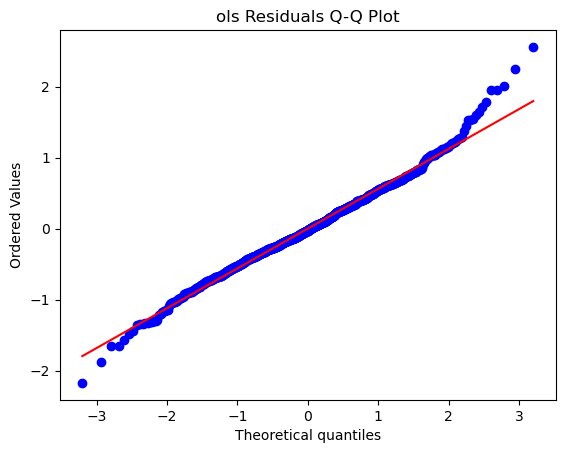

In [78]:
stats.probplot(residuals, dist="norm", plot= plt)
plt.title("ols Residuals Q-Q Plot")


# Tableau

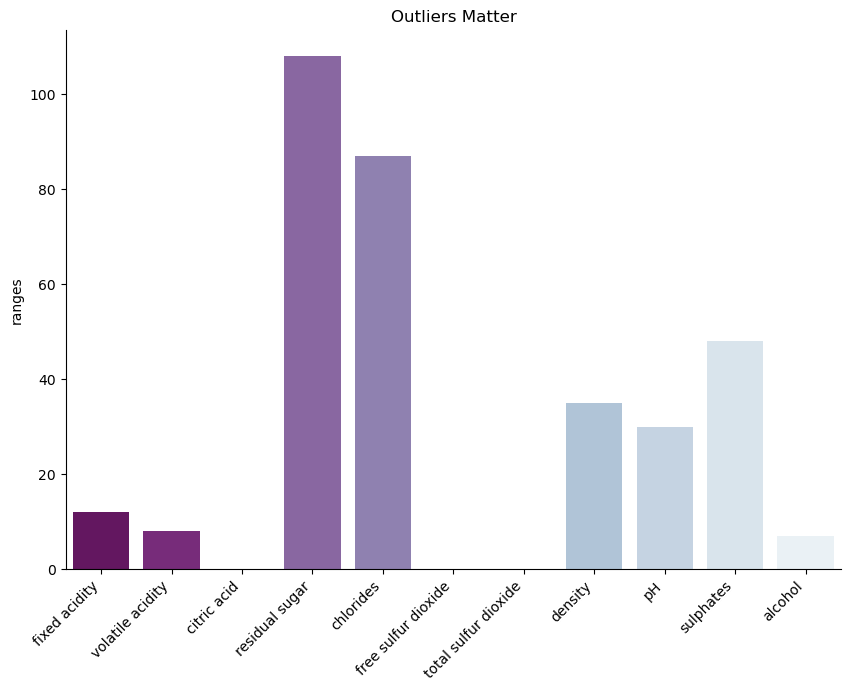

In [90]:
numeric_df = df_log.iloc[:, :-1]
Q1 = df_log.quantile(0.25)
Q3 = df_log.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
 
numeric_df[(numeric_df < lower) | (numeric_df > upper)].count()
outliers = pd.DataFrame({'ranges' :numeric_df[(numeric_df < lower) | (numeric_df > upper)].count()})   

fig, ax = plt.subplots(figsize =(10, 7))
ax.set_title("Outliers Matter")

sns.barplot(x=outliers.index, y=outliers['ranges'], palette="BuPu_r")
plt.xticks(rotation=45, ha='right')  
sns.despine()
plt.show()

Text(0.5, 0.98, 'df_scaled_Standard ECDF')

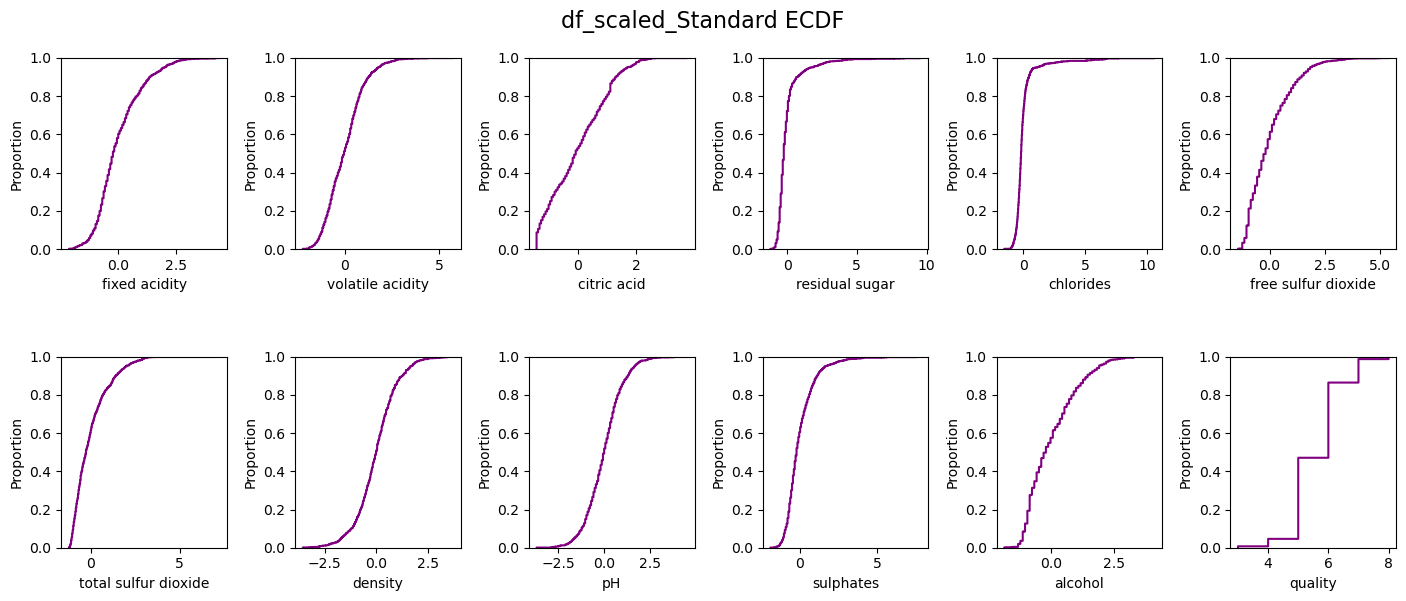

In [105]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(14,6))
index = 0
ax = ax.flatten()

for col, value in df_scaled_S.items():
    legend = index == 0
    sns.ecdfplot(x=col, data=df_scaled_S, ax=ax[index], legend=legend, color='purple')

    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.subplots_adjust(top=0.9)
fig.suptitle("df_scaled_Standard ECDF", fontsize=16)


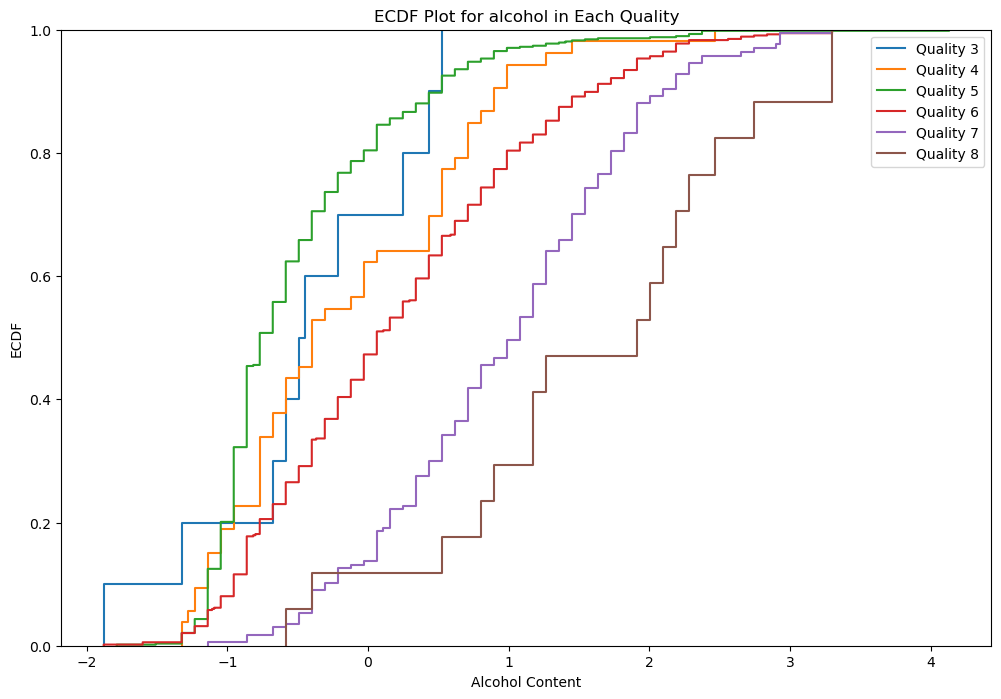

In [113]:
fig, ax = plt.subplots(figsize=(12, 8))  
index = 0 

target_feature = 'alcohol'

for quality_value in sorted(df_scaled_S['quality'].unique()):
    legend = index == 0
    subset_data = df_scaled_S[df_scaled_S['quality'] == quality_value]
    sns.ecdfplot(x=subset_data[target_feature], ax=ax, legend=legend, palette='BuPu_r', label=f'Quality {quality_value}')
    index += 1

ax.set_title(f"ECDF Plot for {target_feature} in Each Quality")
ax.set_xlabel("Alcohol Content")
ax.set_ylabel("ECDF")

ax.legend()

plt.show()

# Conclusion

This model would not do well in the "wild" and should not be considered effective, as a sample of alcohol from any quality comes from a different distribution than alcohol population. 

# Next time

Bayesian optimization: In Bayesian optimization, a probabilistic model is used to model the unknown function that maps hyperparameters to the model’s performance. The model is then used to guide the search for the optimal hyperparameters.

Feature engineering

Handling outliers

# Sources


https://education.molssi.org/python-data-analysis/03-data-fitting/index.html<br>
https://python-graph-gallery.com/heatmap/<br>
https://stackoverflow.com/questions/26414913/normalize-columns-of-a-dataframe<br>
https://www.kaggle.com/code/sonalisingh1411/red-wine-quality-prediction-87-accuracy-using-pca<br>
https://note.nkmk.me/en/python-pandas-multiple-conditions/<br>
https://stackoverflow.com/questions/26414913/normalize-columns-of-a-dataframe<br>
https://matheusfacure.github.io/python-causality-handbook/01-Introduction-To-Causality.html<br>
https://napsterinblue.github.io/notes/python/viz/subplots/<br>
https://pbpython.com/effective-matplotlib.html<br>
https://www.kaggle.com/code/asimislam/tutorial-python-subplots#4.--Subplots-with-FOR-Loop---example-#1<br>
https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html<br>
https://fcpython.com/visualisation/creating-multiple-visualisations-in-python-with-subplots<br>
https://stackoverflow.com/questions/63307440/how-to-plot-a-mean-line-on-a-kdeplot-between-0-and-the-y-value-of-the-mean<br>
http://fmwww.bc.edu/repec/bocode/t/transint.html<br>
https://python-graph-gallery.com/2-horizontal-barplot/<br>
https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises<br>
https://www.codecademy.com/article/normalization<br>
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section<br>
https://d-nb.info/1221556479/34<br>
https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/<br>
https://datascience.stackexchange.com/questions/113403/how-much-percentage-of-outliers-are-allowed-in-a-data<br>
https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/<br>
https://medium.com/analytics-vidhya/outlier-detection-with-python-79a82514223b<br>
https://fcpython.com/machine-learning/introduction-to-simple-linear-regression-in-python<br>
https://github.com/BioWar/Python-Machine-Learning/blob/master/   <br>
https://github.com/BioWar/Python-Machine-Learning/blob/master/Predicting%20Continuous%20Target%20Variables%20with%20Regression%20Analysis.ipynb<br>
https://www.kaggle.com/code/tolgadincer/continuous-target-stratification<br>
https://www.kaggle.com/code/kdsharma/predicting-wine-quality-88-accuracy#🎯-Model-Creation-using-RandomForest-🎯<br>
https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python<br>
https://aegis4048.github.io/transforming-non-normal-distribution-to-normal-distribution<br>
https://aegis4048.github.io/transforming-non-normal-distribution-to-normal-distribution<br>
https://www.youtube.com/watch?v=c6EHXGmFN8c&list=PLe9UEU4oeAuV7RtCbL76hca5ELO_IELk4&index=2<br>
https://forecastegy.com/posts/feature-importance-in-logistic-regression/<br>
https://www.kaggle.com/code/dansbecker/shap-values<br>